In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as msqe
from sklearn.metrics import r2_score as r2


In [11]:
features = ['sex', 'exp1', 'exp2', 'exp3', 'exp4', 'shs', 'hsg', 'occ2', 'ind2', 'mw', 'so', 'we']
target = ['lwage']

In [38]:
wage = pd.read_csv("./data/wage2015_subsample_inference.csv")
wage_long = wage.melt(id_vars = ['rownames', 'wage', 'lwage', 'sex', 'mw', 'so', 'we', 'ne', 'exp1', 'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'])
wage_long = wage_long[wage_long.value>0]

In [45]:
wage_long['College'] = wage_long["variable"].isin(["scl", "clg"])

### Plots

<AxesSubplot:xlabel='variable', ylabel='wage'>

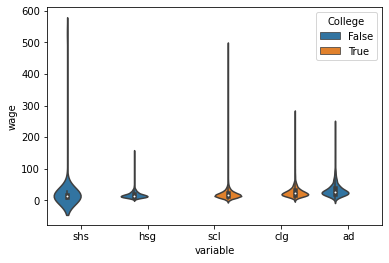

In [46]:
sns.violinplot(x = "variable", y = "wage", hue = 'College', data = wage_long)

<AxesSubplot:xlabel='variable', ylabel='lwage'>

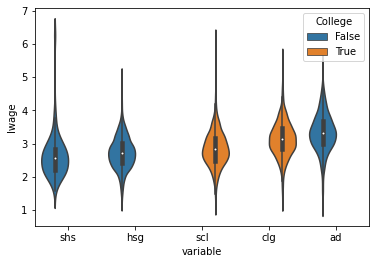

In [47]:
sns.violinplot(x = "variable", y = "lwage", data = wage_long, hue = "College")

<AxesSubplot:xlabel='sex', ylabel='wage'>

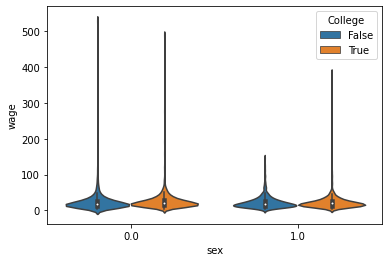

In [49]:
sns.violinplot(x = "sex", y = "wage", hue = "College", data = wage_long)

<AxesSubplot:xlabel='sex', ylabel='lwage'>

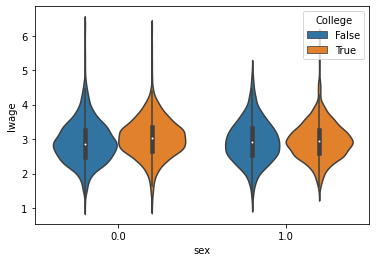

In [50]:
sns.violinplot(x = "sex", y = "lwage", hue = "College", data = wage_long)

<AxesSubplot:xlabel='sex', ylabel='exp1'>

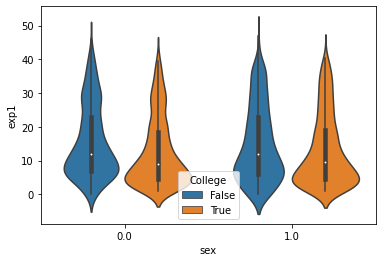

In [51]:
sns.violinplot(x = "sex", y = "exp1", hue = "College", data = wage_long)

c:\users\jhon\appdata\local\programs\python\python37\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


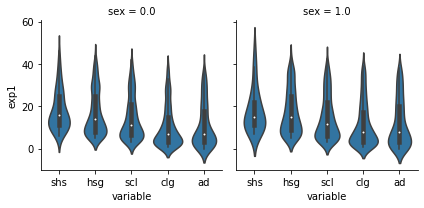

In [118]:
g = sns.FacetGrid(wage_long, col = "sex")
g.map(sns.violinplot, "variable", "exp1")

### Models

In [26]:
wage_y = wage[target]
wage_x = wage[features]

x_tr_wg, x_ts_wg, y_tr_wg, y_ts_wg = train_test_split(
  wage_x, wage_y, test_size = .4, random_state = 12
)

x_tr_wg["lwage"] = y_tr_wg
x_ts_wg['lwage'] = y_ts_wg

tr_wg =  pd.DataFrame(x_tr_wg) 
ts_wg = pd.DataFrame(x_ts_wg)


### 

ols = ' lwage ~ sex + exp1 + shs + hsg + mw + so + we + occ2 + ind2'
flex = ' lwage ~ sex+(exp1+exp2+exp3+exp4+shs+hsg +occ2+ind2 + mw + so + we)**2'

ols_reg = smf.ols(ols, data = tr_wg).fit()
flx_reg = smf.ols(flex, data = tr_wg).fit()

mse =  [
    msqe(y_tr_wg, ols_reg.predict(x_tr_wg)),
    msqe(y_ts_wg, ols_reg.predict(x_ts_wg)),
    msqe(y_tr_wg, flx_reg.predict(x_tr_wg)),
    msqe(y_ts_wg, flx_reg.predict(x_ts_wg))
  ]

r_2 =  [
    r2(y_tr_wg, ols_reg.predict(x_tr_wg)),
    r2(y_ts_wg, ols_reg.predict(x_ts_wg)),
    r2(y_tr_wg, flx_reg.predict(x_tr_wg)),
    r2(y_ts_wg, flx_reg.predict(x_ts_wg))
  ]
  

ref = {
  'Models' : ["Basic OLS", "Basic OLS", "Flexible OLS", "Flexible OLS"],
  'Type' : ["train", "test", "train", "test"]
  , "mse" : mse
  , "r2" : r_2
}
pd.DataFrame(ref)

,Models,Type,mse,r2
0,Basic OLS,train,0.275718,0.179506
1,Basic OLS,test,0.256585,0.169958
2,Flexible OLS,train,0.266181,0.207887
3,Flexible OLS,test,0.254452,0.176859


### Coefplots

In [103]:
coef_ref = {
    "Model": ["Basic OLS", "Flexible OLS"],
    "coef": [ols_reg.params.values[1], flx_reg.params.values[1]],
    "err": [(ols_reg.params - ols_reg.conf_int()[0])[1], (flx_reg.params - flx_reg.conf_int()[0])[1]]
}
coef_ref = pd.DataFrame(coef_ref)
coef_ref


,Model,coef,err
0,Basic OLS,-0.112061,0.038963
1,Flexible OLS,-0.106377,0.038958


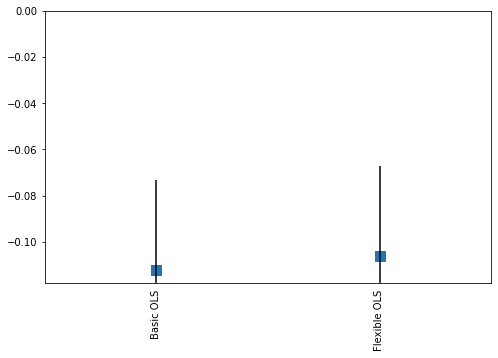

In [117]:
fig, ax = plt.subplots(figsize=(8, 5))
coef_ref.plot(x = "Model", y = "coef", kind = "bar", ax = ax, color = "none",yerr = "err", legend = False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.xaxis.set_ticks_position('none')
ax.scatter(x = coef_ref["Model"], y = coef_ref["coef"], marker = 's', s = 120)

### Wage - Experience

In [67]:
wage_exp = wage[['lwage', 'clg', 'hsg', 'exp1']]
wage_exp1 = wage_exp.melt(id_vars = ['lwage', 'exp1'])
wage_exp1 = wage_exp1[wage_exp1.value>0]
wage_exp1

,lwage,exp1,variable,value
0,2.263364,7.0,clg,1.0
1,3.872802,31.0,clg,1.0
4,3.361977,22.0,clg,1.0
5,2.462215,1.0,clg,1.0
9,2.956512,4.0,clg,1.0
...,...,...,...,...
10285,2.563469,15.0,hsg,1.0
10287,2.599837,8.0,hsg,1.0
10291,3.117780,15.0,hsg,1.0
10292,2.822980,11.0,hsg,1.0


Text(0, 0.5, 'Log Wage')

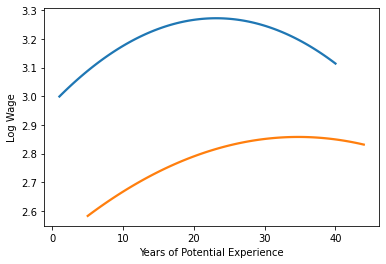

In [121]:
sns.regplot(x = "exp1", y = "lwage", data = wage_exp1[wage_exp1.variable == "clg"], scatter = False, ci = None, order = 2)
sns.regplot(x = "exp1", y = "lwage", data = wage_exp1[wage_exp1.variable == "hsg"], scatter = False, ci = None, order = 2)
plt.xlabel("Years of Potential Experience")
plt.ylabel("Log Wage")